# CSI 4106 Introduction to Artificial Intelligence 
## Assignment 2: Machine Learning

## Report Title: Data Preparation, Model Development and Parameter Optimization for Machine Learning

### Identification

Name: Alex Govier <br/>
Student Number: 300174954

#### Import Necessary Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import classification_report

### Exploratory Analysis

#### 1. Loading Dataset and Summary

In [14]:
# Loading the diabetes dataset from my GitHub
diabetes_url = "https://github.com/alex-govier5/intro-to-ai/raw/master/A2/diabetes_prediction_dataset.csv"
dataset = pd.read_csv(diabetes_url)

print(dataset.head(5))

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


This is a large dataset of around 100,000 rows containing patient's medical information. It has their gender which is categorical, it has their age which is numerical, it has hypertension which is categorical in binary indicating whether the patient has hypertension or not, it has heart_disease which is also categorical and binary indicating if the patient has heart disease or not, it has smoking_history which is categorical indicating they're smoking habits, it has bmi which is numerical indicating the patient's body mass index, it has the HbA1c_level, indicating the patient's Hemoglobin A1c level, it has the bloode_glucose_level which is numerical, indicating the patient's blood sugar level, and then finally it has diabetes which is the target variable which is categorical and binary, indicating whether the patient has diabetes or not (0 = No, 1 = Yes).

#### 2. Feature Distribution Analysis
Here I will visualize all of my attributes and then provide an analysis.

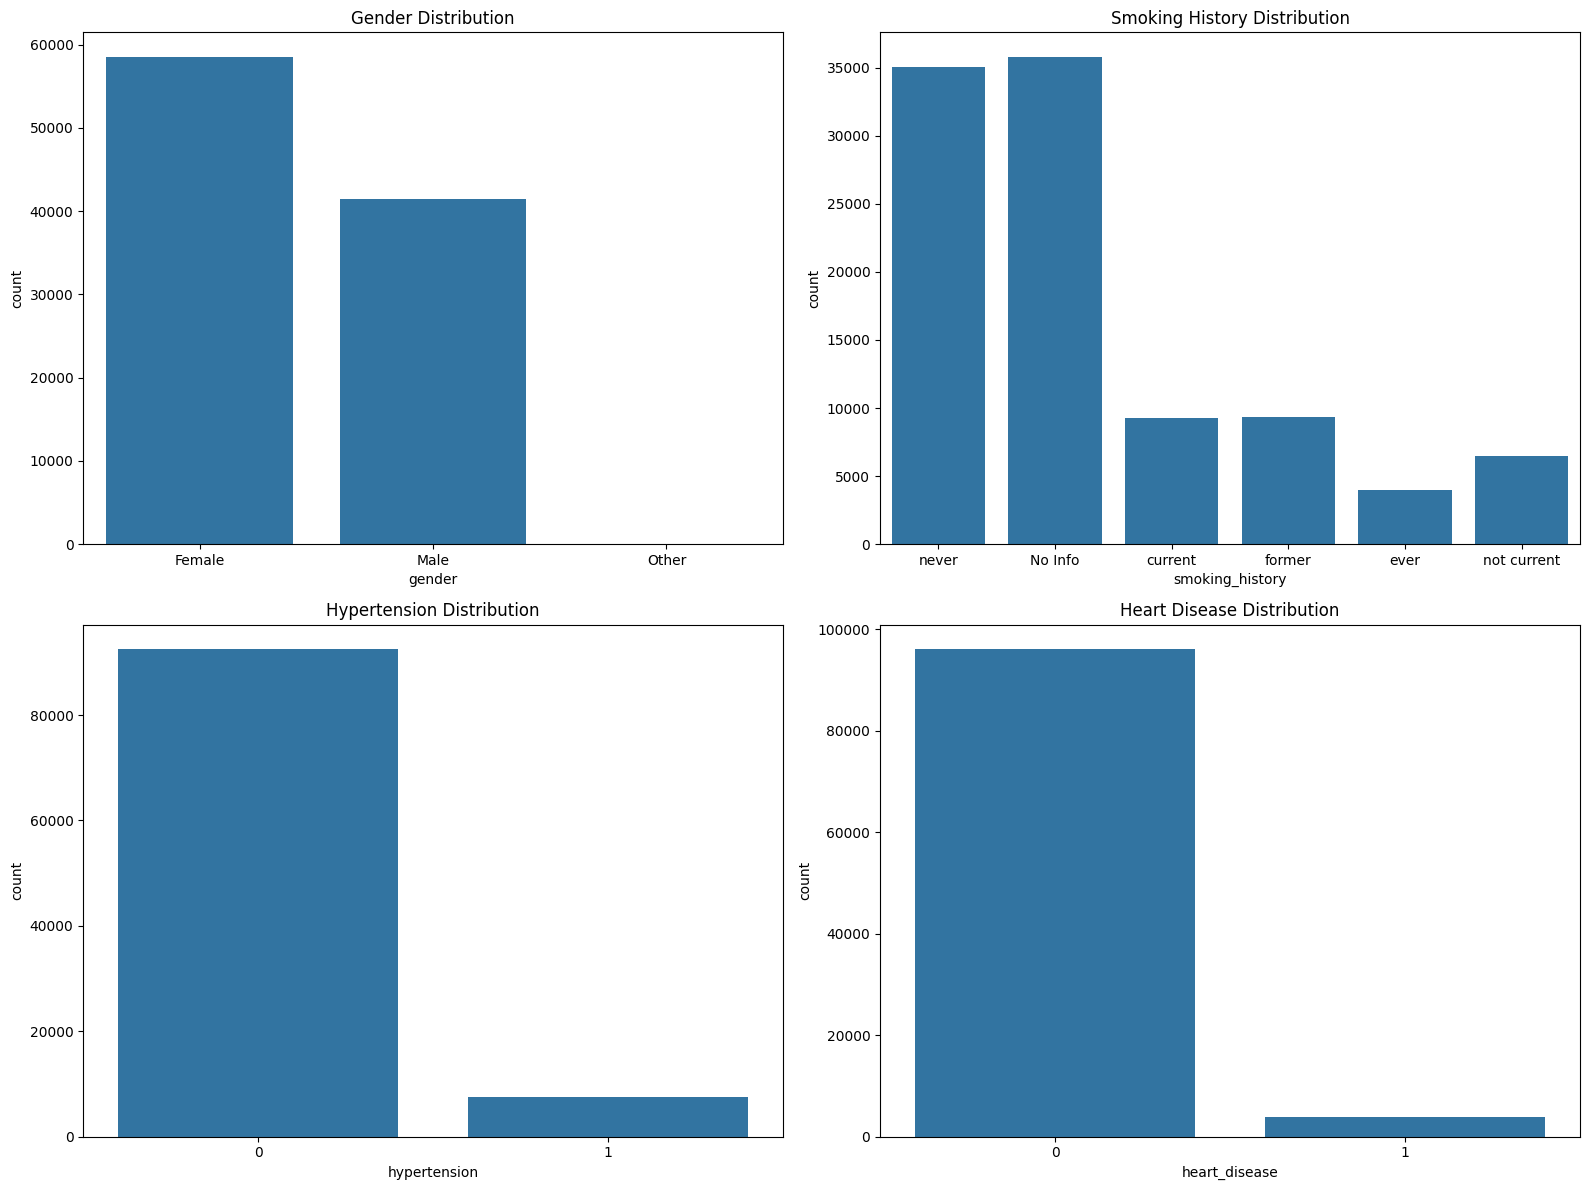

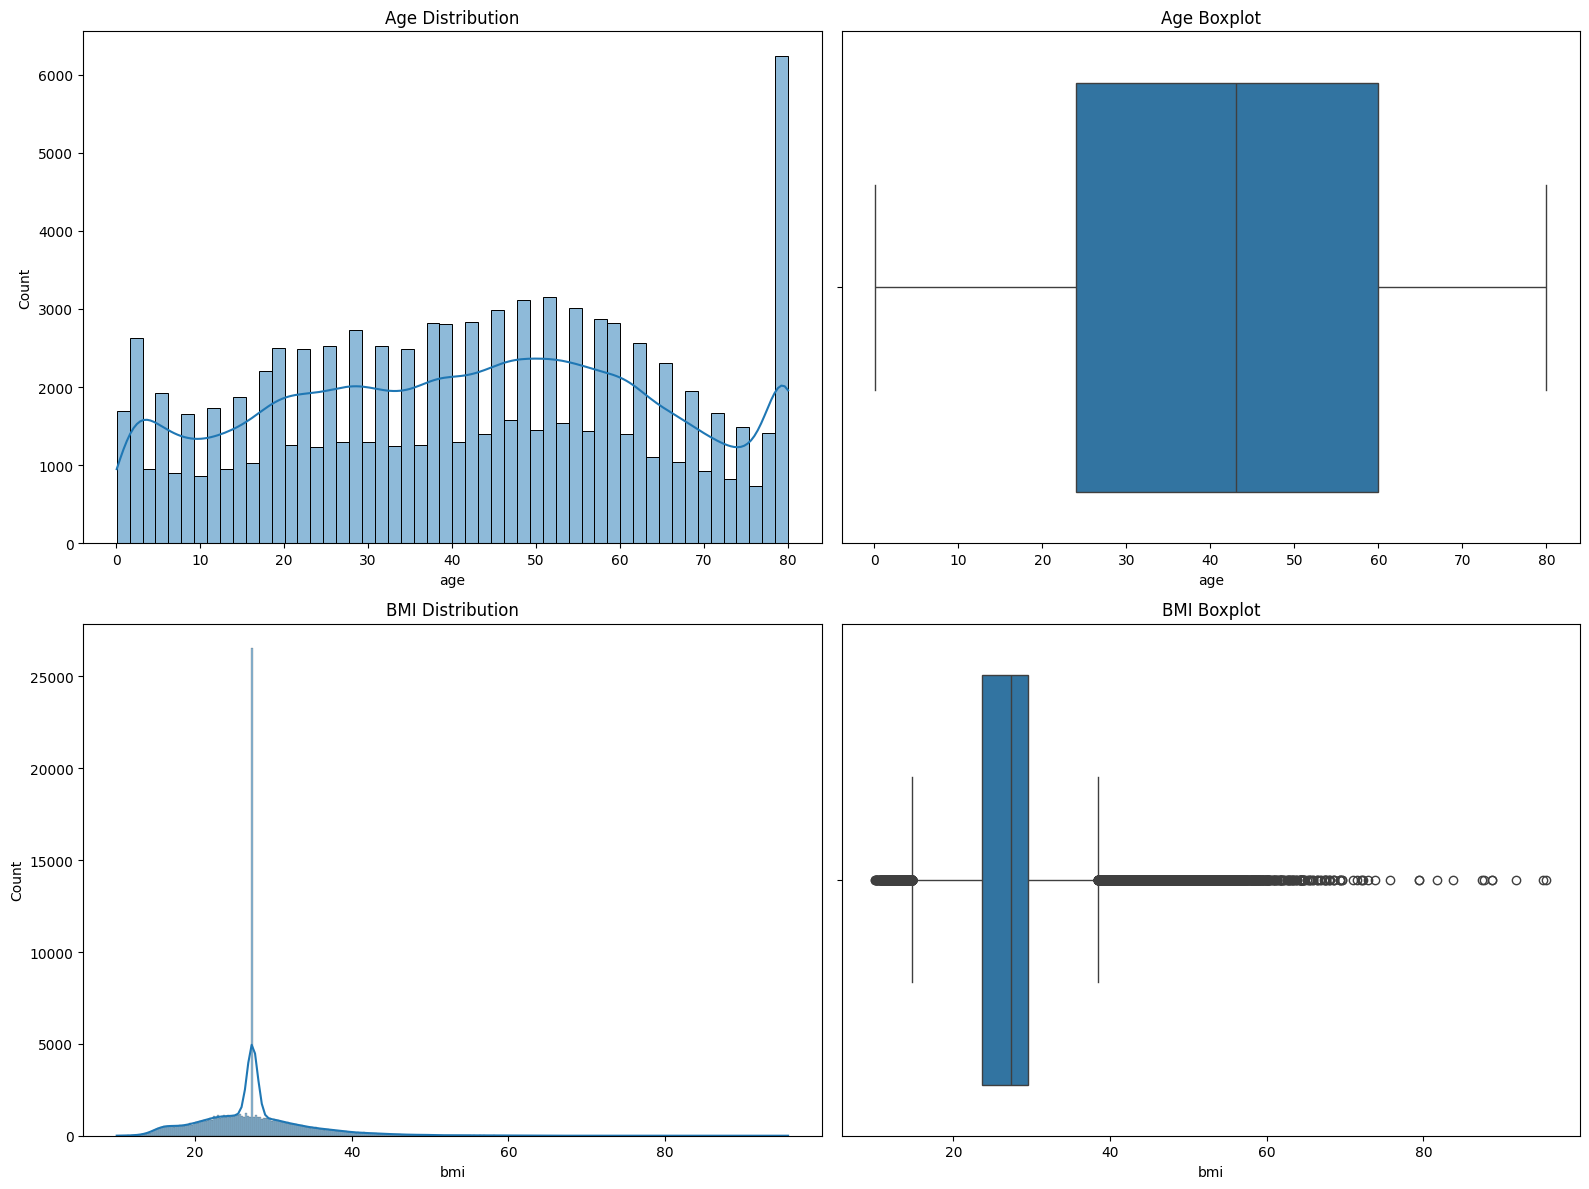

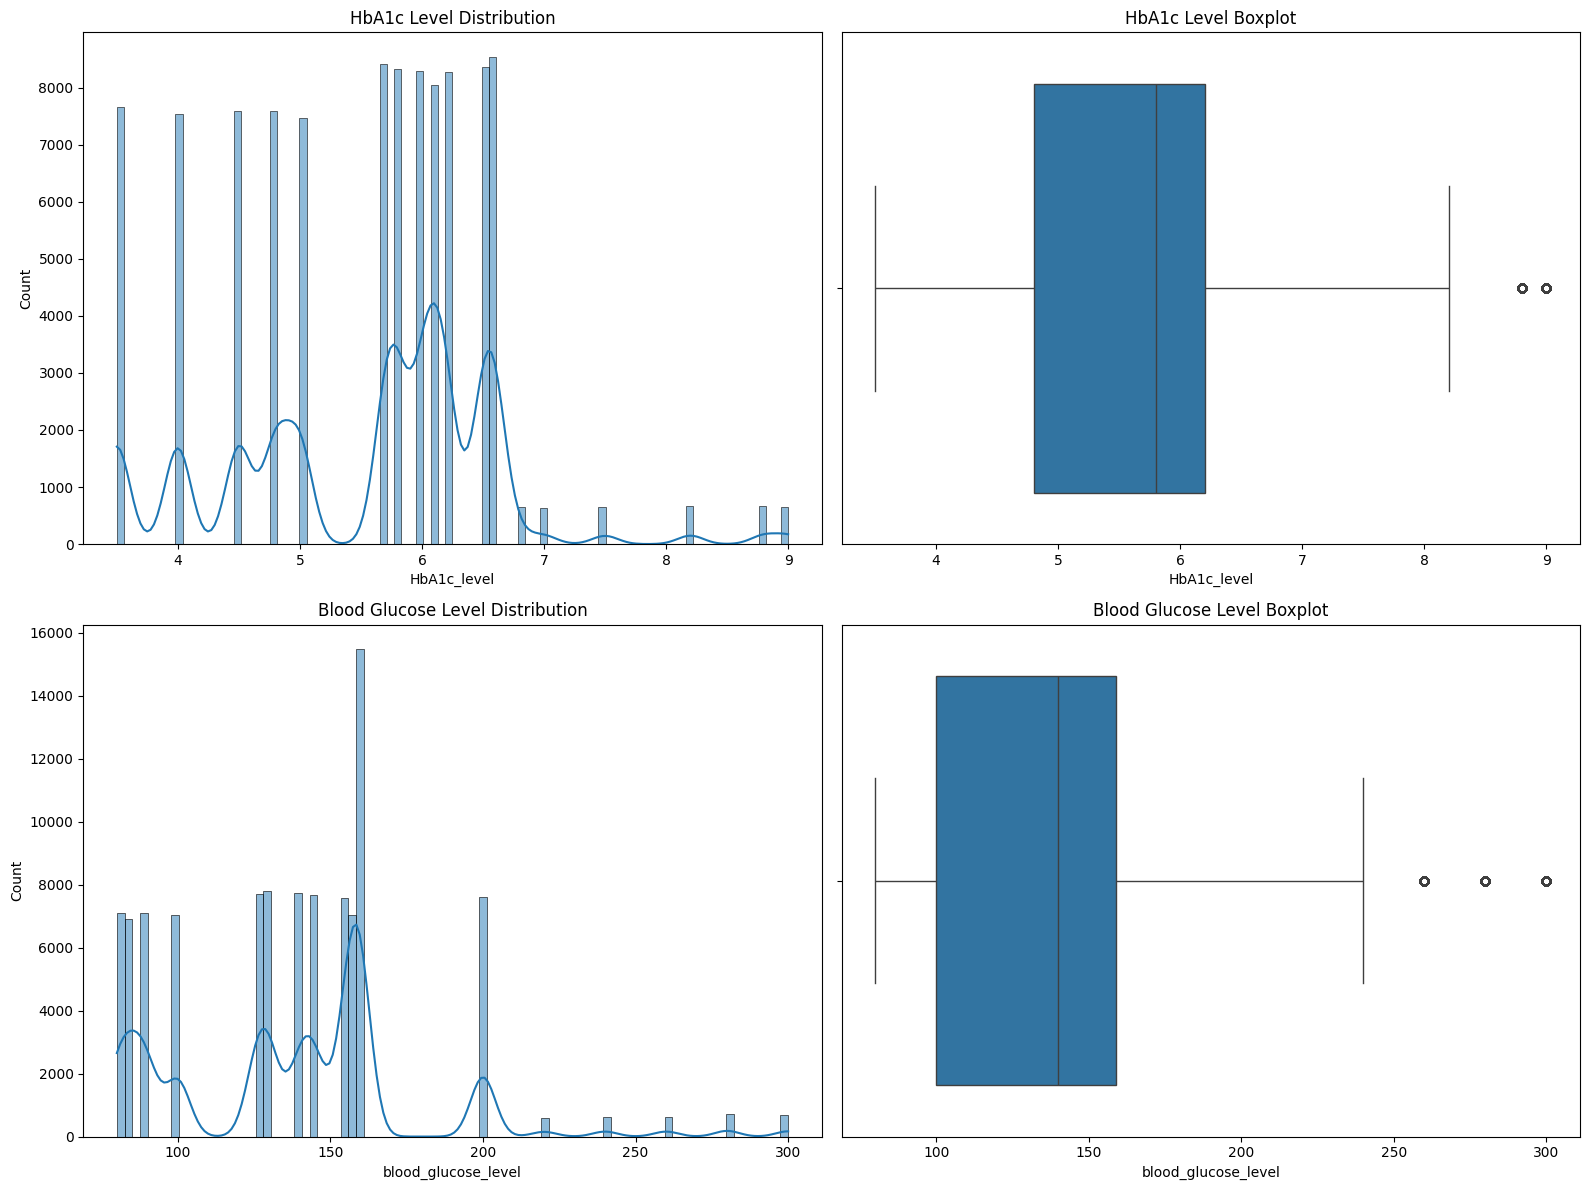

In [15]:
# Convert the dataset to a dataframe
df = pd.DataFrame(dataset)

# Will separate visualizations by type, so countplots for categorical attributes
plt.figure(figsize=(16, 12))

# Gender
plt.subplot(2, 2, 1)
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')

# Smoking history
plt.subplot(2, 2, 2)
sns.countplot(x='smoking_history', data=df)
plt.title('Smoking History Distribution')

# Hypertension
plt.subplot(2, 2, 3)
sns.countplot(x='hypertension', data=df)
plt.title('Hypertension Distribution')

# Heart disease
plt.subplot(2, 2, 4)
sns.countplot(x='heart_disease', data=df)
plt.title('Heart Disease Distribution')

plt.tight_layout()
plt.show()

# Histograms and boxplots for numerical attributes

plt.figure(figsize=(16, 12))

# Age
plt.subplot(2, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')

plt.subplot(2, 2, 2)
sns.boxplot(x=df['age'])
plt.title('Age Boxplot')

# BMI 
plt.subplot(2, 2, 3)
sns.histplot(df['bmi'], kde=True)
plt.title('BMI Distribution')

plt.subplot(2, 2, 4)
sns.boxplot(x=df['bmi'])
plt.title('BMI Boxplot')

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))

# HbA1c
plt.subplot(2, 2, 1)
sns.histplot(df['HbA1c_level'], kde=True)
plt.title('HbA1c Level Distribution')

plt.subplot(2, 2, 2)
sns.boxplot(x=df['HbA1c_level'])
plt.title('HbA1c Level Boxplot')

# Blood glucose
plt.subplot(2, 2, 3)
sns.histplot(df['blood_glucose_level'], kde=True)
plt.title('Blood Glucose Level Distribution')

plt.subplot(2, 2, 4)
sns.boxplot(x=df['blood_glucose_level'])
plt.title('Blood Glucose Level Boxplot')

plt.tight_layout()
plt.show()


For gender, the dataset may be skewed towards females, which could affect the model, the Other category appears to be negligible in this case. <br/>
For smoking history, the high count of No Info means there is a lot of missing data here, this may affect meaningful analysis, and current smokers are less represented than never smokers, so this could affect the model as well.<br/> 
For hypertension, majority of patients don't have hypertension, this imbalance could affect the model training to make it a bit biased, the same can be said with heart disease, vast majority don't have heart disease so the same problem could arise. <br/>
The age attribute is well distributed with a large spike in patients over 80 which makes sense in this case, there doesn't seem to be any significant outliers here. <br/>
The BMI distribution is highly skewed with a large peak around a specific value around 20, so most individuals in the dataset have a BMI close to the median or mean, however there are a lot of outliers here at the upper end so a few people have a quite high BMI. <br/>
The HbA1c distribution is uneven, with indicators of binning, so it might not have been continuous but rather in intervals, there are a few outliers which means some people have a significantly higher Hb1Ac level. <br/>
The blood glucose distribution is also uneven and also indicates that values were maybe taken in intervals or rounded, there are a few peaks and a long tail so some people have very high blood glucose, there are many outliers at the higher end, those people are likely at a higher risk for diabetes.<br/>
So, overall, there is much to consider with this dataset, some good distributions, some poor, and quite a few outliers at upper ends of the spectrums. So the data preprocessing will be a very important step.

#### 3. Target Variable Distribution
Here I will analyze the distribution of the target variable to identify class imbalances.

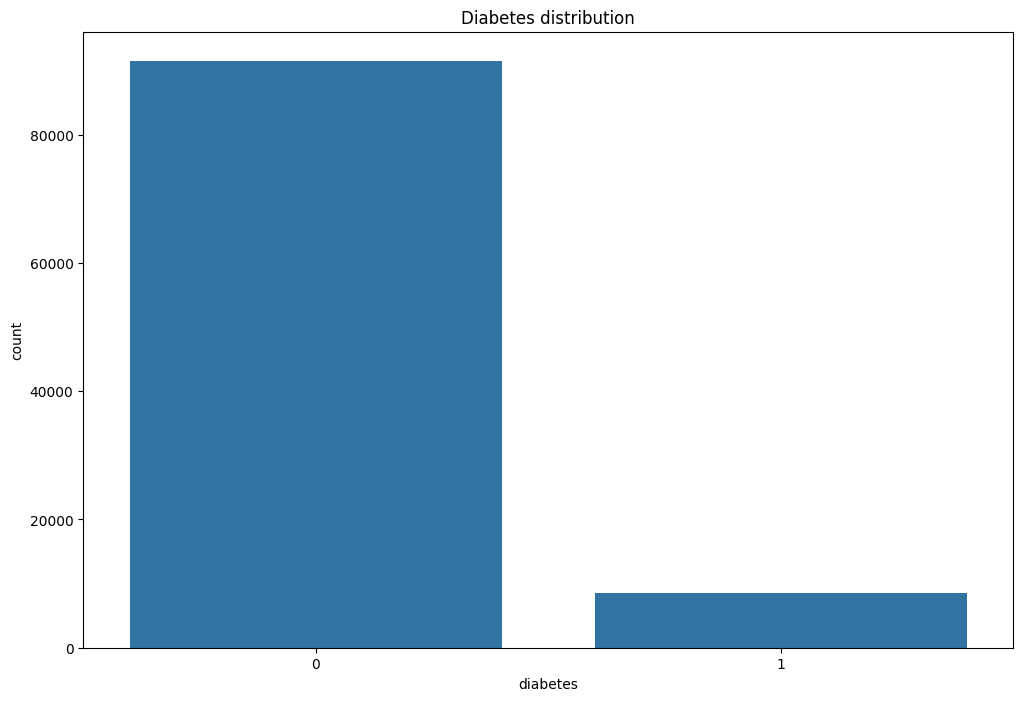

In [16]:
# Visualize distribution for diabetes
df = pd.DataFrame(dataset)

plt.figure(figsize=(12, 8))

sns.countplot(x='diabetes', data=df)
plt.title('Diabetes distribution')
plt.show()

So as we can see here, the target variable is very imbalanced with almost all cases not having diabetes. This may affect the performance of the machine learning models, especially when predicting the minority class, the classifiers will be biased towards the majority class (negative cases). Usually in this case, tools like undersampling or oversampling could be used to mitigate this. (Professor Turcotte mentioned he tried using these techniques however and they didn't quite work).

#### 4. Data Splitting
Here I will split the data before preprocessing to avoid any data leakage.

In [17]:
# Assign values X and y
X = df.drop(columns="diabetes") # Includes every column except the target variable

y = df["diabetes"] # Target column

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

So I have split the data, random state = 42 ensures that the split is reproducible every time the code is run, and stratify=y helps keep the same distribution of the target variable in both training and test sets, which is important when the dataset is imbalanced like ours is.

#### 5. Categorical Variable Encoding
Here I will encode the categorical variables.

In [18]:
# Encoding categorical variables
categorical_cols = ['gender', 'smoking_history']

encoder = OneHotEncoder(sparse_output=False)

# Encode training data
encoded_train_data = encoder.fit_transform(X_train[categorical_cols])

encoded_train_df = pd.DataFrame(encoded_train_data, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)

X_train = pd.concat([X_train.drop(columns=categorical_cols), encoded_train_df], axis=1)

# Encode test data
encoded_test_data = encoder.transform(X_test[categorical_cols])

encoded_test_df = pd.DataFrame(encoded_test_data, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)

X_test = pd.concat([X_test.drop(columns=categorical_cols), encoded_test_df], axis=1)

My categorical columns here are gender, smoking history, heart disease, and hypertension. Heart disease and hypertension are already encoded as 1s and 0s, so I did not need to apply any transformations to those columns since they will already work with machine learning models. For gender and smoking history, I decided to use one hot encoding because it's useful when building pipelines for preprocessing data before feeding into machine learning models. It also gives more flexibility. I considered ordinal encoding for smoking history, but that would only be appropriate if there was an order to the categories, but there didn't seem to be a clear order or ranking so one hot encoding made more sense. index=X_train.index and index=X_test.index make sure that the indices of the encoded data match the original data so that no extra rows are added. I made sure to use fit transform on the training set and only transform on the test set this way the transformer learns the necessary parameters (e.g., mean and standard deviation for scaling) solely from the training data and by only using transform on the test data, I will prevent the model from being influenced by any information from the test set.

#### 6. Transforming Numerical Features
Here I will apply transformations to the numerical features.

In [19]:
# Scale numerical features

# Normalize age
normalization = MinMaxScaler()

# Fit only on the training data and transform the training set
X_train['age'] = normalization.fit_transform(X_train[['age']])

# Apply the same transformation on the test set (without refitting)
X_test['age'] = normalization.transform(X_test[['age']])

# Log transform BMI
X_train['bmi'] = np.log(X_train['bmi'] + 1)
X_test['bmi'] = np.log(X_test['bmi'] + 1)

# Perform standardization on Hb1Ac
standardization = StandardScaler()

# Fit only on the training data and transform the training set
X_train['HbA1c_level'] = standardization.fit_transform(X_train[['HbA1c_level']])

# Apply the same transformation on the test set (without refitting)
X_test['HbA1c_level'] = standardization.transform(X_test[['HbA1c_level']])

# Log transform Blood glucose
X_train['blood_glucose_level'] = np.log(X_train['blood_glucose_level'] + 1)
X_test['blood_glucose_level'] = np.log(X_test['blood_glucose_level'] + 1)

For age I decided to use normalization, this method scales values to a range between 0 and 1. Given that age spans a range from 0 to about 80, this method will work well since I'm using models that is sensitive to feature magnitude, like K-Nearest Neighbors. It will help ensure that age is on the same scale as other features, preventing it from disproportionately influencing the models. For BMI I decided to use a log transformation, this method is used to handle skewed data, and it will help here. Applying a log transformation will compress the larger BMI values, reducing the effect of the extreme outliers and making the distribution more manageable for my models. For BMI, which is strongly right-skewed, the log transformation will likely improve model performance by better capturing the relationships between BMI and the target. For Hb1Ac I decided to use standardization, this is a good strategy in this case because the distribution shows wide variation with multiple peaks and some outliers. Standardization rescales the data such that it has a mean of 0 and a standard deviation of 1. This helps to remove biases caused by different scales or outliers, making it easier for machine learning models to converge and perform better. Finally, I decided to use log transformation for blood glucose as well because the data is right-skewed with several extreme outliers. A log transformation will compress the higher glucose values and bring the distribution closer to normality. This transformation can help manage both the skewness and the outliers effectively.

#### 7. Model Development
Here I will implement machine learning models with default parameters.

In [20]:
# Implementing models
dt_model = DecisionTreeClassifier(random_state=42)
knn_model = KNeighborsClassifier()
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Training decision tree
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

# Training KNN
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

# Training logistic regression
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

So I implemented the three models seen in class. I used the default parameters of random state = 42 to ensure reproducibility of the results, I also used a max iterations of 1000 for logistic regression to ensure convergence. I will now evaluate these models and see how I can tune the parameters to improve the results.

#### 8. Model Evaluation
Here I will evaluate how my models performed using different metrics.

In [21]:
# Evaluate the models
models = {
    'Decision Tree': dt_model,
    'K-Nearest Neighbors': knn_model,
    'Logistic Regression': lr_model
}

# Number of folds for cross-validation
n_folds = 5

# Evaluate each model using cross-validation
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=n_folds, scoring='f1')
    print(f"{name} - Cross-Validation F1 Scores: {cv_scores}")
    print(f"{name} - Mean F1 Score: {cv_scores.mean():.4f}")

    # Fit the model and make predictions for classification report
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Print classification report
    print(f"\n{name} Classification Report:\n", classification_report(y_test, preds))

Decision Tree - Cross-Validation F1 Scores: [0.72565109 0.71629924 0.71939871 0.71485077 0.70972372]
Decision Tree - Mean F1 Score: 0.7172

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97     18300
           1       0.70      0.74      0.72      1700

    accuracy                           0.95     20000
   macro avg       0.84      0.85      0.85     20000
weighted avg       0.95      0.95      0.95     20000

K-Nearest Neighbors - Cross-Validation F1 Scores: [0.75753715 0.7455876  0.75160875 0.74685193 0.74206177]
K-Nearest Neighbors - Mean F1 Score: 0.7487

K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.90      0.65      0.76      1700

    accuracy                           0.96     20000
   macro avg       0.93      0.82      0.87     20000
weighted avg       0.96    

So here I evaluate my models, I use cross validation and see the F1 score using 5 folds. I chose 5 because it's a good balance that should make sure the model generalizes well without too much overhead, with 2-3 folds, the variance of the performance estimate might be higher, with more folds like 10, the bias might be reduced, but the cost is higher. I used F1 so that it balances precision and recall. I then generate a classification report which, after training each model, generates predictions for the test set and shows a report with the precision, recall and F1 score for each class. </br>
For the results, the decision tree had an average F1 score of 0.7172 which is fairly good considering it used default parameters, it had very high precision and recall scores for the negative class, but slightly poorer results for the positive class which was to be expected given that there were far fewer examples from the positive class. KNN had a mean F1 score of 0.7487 which is a good improvement, but similar issues with the classification for the negative class vs positive class, but with a slightly higher overall accuracy score. Logistic regression finished slightly above decision tree, with a mean F1 score of 0.7199, with similar issues with the classification but an overall accuracy score of 96%. </br>
So now I will try and tune the parameters to improve on these results.

#### 9. Exploration and Performance Evaluation
Here I will look at the impact of varying hyperparameters on the performance of each model.

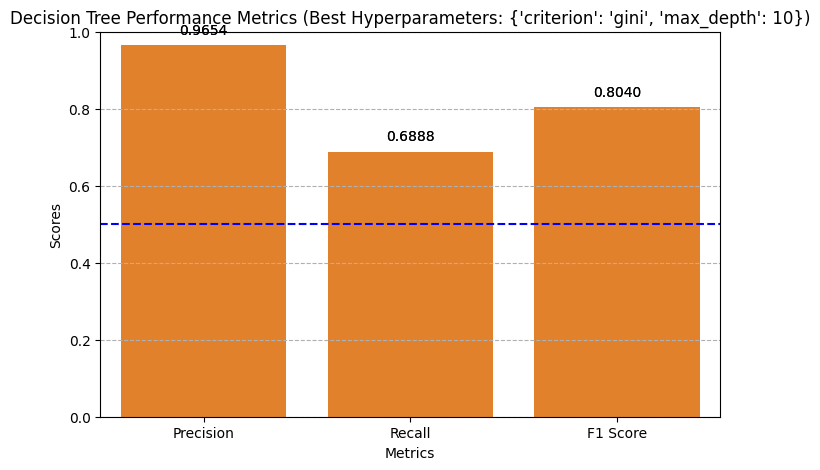

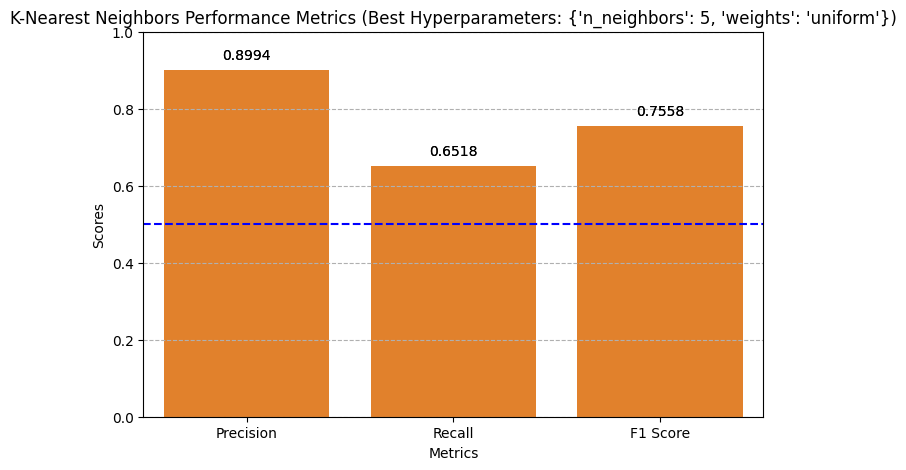

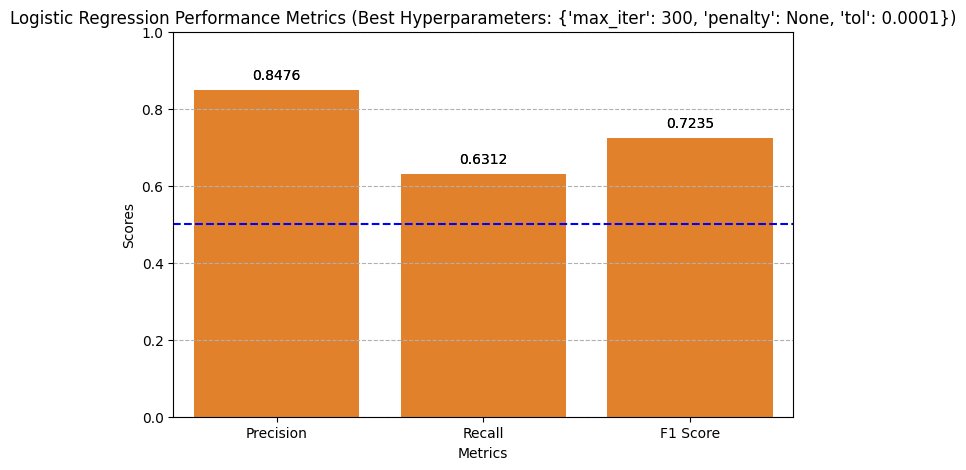

In [22]:
# Test hyperparameters

param_grids = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15, 20]
    },
    'Logistic Regression': {
        'penalty': ['l2', None],
        'max_iter': [300, 500, 1000],
        'tol': [1e-4, 1e-3, 1e-2]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance']
    }
}

# Dictionary to store the best performance metrics
best_performance_results = []

# Perform grid search for each model
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', return_train_score=False)
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator for the model
    best_estimator = grid_search.best_estimator_
    
    # Predict on the test set
    preds = best_estimator.predict(X_test)
    
    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    # Store the best performance metrics
    best_performance_results.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Best Hyperparameters': grid_search.best_params_
    })

# Create a DataFrame from the best performance results
best_performance_df = pd.DataFrame(best_performance_results)

# Set the number of models
models_count = len(best_performance_df)

# Create bar plots for each model
for index in range(models_count):
    model_name = best_performance_df.loc[index, 'Model']
    metrics = best_performance_df.loc[index, ['Precision', 'Recall', 'F1 Score']]

    plt.figure(figsize=(8, 5))
    bars = sns.barplot(x=metrics.index, y=metrics.values)
    sns.barplot(x=metrics.index, y=metrics.values)
    plt.title(f'{model_name} Performance Metrics (Best Hyperparameters: {best_performance_df.loc[index, "Best Hyperparameters"]})')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.ylim(0, 1)  
    plt.axhline(y=0.5, color='blue', linestyle='--')  
    plt.grid(axis='y', linestyle='--')
    for bar in bars.patches:
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.02, 
            f'{bar.get_height():.4f}',  
            ha='center',  
            va='bottom' 
        )
    plt.show()


So here I set up my parameters so that I had a good variety to test with, focusing on criterion and max depth for decision tree, penalty, max iterations and tol for logistic regression and number of neighbors and weights for KNN. I then utilized grid search with a 5-fold cross validation to test out the different configurations, where the scoring was focused on the F1 score. I then identified the best estimator and predicted with that to get updated precision, recall and F1 scores for the best configurations. I then create a dataframe with my results and create a graph for each model with the best configuration, showing the improved precision, recall and F1 scores. </br>
For the results, the Decision Tree model came out as by far the best, with the Gini criterion and a max depth of 10. This configuration likely gave a balance between model complexity and interpretability, allowing the model to capture the underlying patterns in the data without overfitting. It had a massive improvement from an initial mean F1 score of around 0.7172 to 0.8040, showing that this combination effectively optimized the model's performance. Also, it also had the highest precision and recall scores out of all the best configurations, showing its ability to correctly identify positive instances while minimizing false positives and false negatives.
For KNN, it had an original mean F1 score of 0.7487 and barely saw an improvement, with the best F1 score at 0.7558. This small increase suggests that the model was already well-tuned to the dataset, and the best configuration—5 nearest neighbors and uniform weights—was effective in keeping stability in the predictions. However, it had a slightly better precision score than logistic regression and recall score, showing that while it was good at correctly identifying positive instances, it also found a decent number of actual positives.
Logistic regression went from a mean F1 score of 0.7199 to 0.7235, a small improvement. This enhancement can be attributed to the configuration of 300 max iterations, no penalty, and a tolerance of 0.0001, which allowed the optimization algorithm enough time to converge while maintaining a straightforward linear decision boundary. The model got decent scores for recall and precision, showing its ability to balance false positives and false negatives effectively in this context.</br>
The data imbalance in the dataset definitely affected each model, because each had a much lower recall score compared to precision, meaning it was very good at identifying patients with diabetes, but wasn't as good at actually finding all of them because there were so few positive examples in the dataset. So considering the lack of data the models had to work with, they performed fairly well. </br>
The clear winner here is the decision tree since it had the highest precision, recall and F1 scores, so this is the model I will select for the final part. And I will make sure to use the parameters I found to be the best which were the Gini criterion and a max depth of 10.

#### 10. Model Comparison
Here I will train the recommended model using the optimal parameter values identified from the parameter optimization step, then apply the trained model to the test data. In the assignment document, it asks to compare the results of each model with the different parameters, but I found it made more sense to include that in the previous section with the results so that the discussion could be directly tied to the results. So from the previous section, I have decided to use the decision tree with the Gini criterion and a max depth of 10.

In [23]:
# Train the recommended model
best_dt_model = DecisionTreeClassifier(criterion='gini', max_depth=10)

# Train the model using the training data
best_dt_model.fit(X_train, y_train)

# Make predictions on the test data
dt_predictions = best_dt_model.predict(X_test)

# Print the classification report for the Decision Tree model
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_predictions))

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.97      0.69      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.97      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



The decision tree model trained with the Gini criterion and a maximum depth of 10 achieved great results on the test dataset, as shown in the classification report. These results align well with the observations made during the hyperparameter tuning phase, where this configuration was identified as the best-performing setup. </br>

Precision: The model had high precision, getting a score of 0.97 for both classes (0 and 1). This shows that the model is very effective at correctly identifying positive instances (class 1), with only a small fraction of false positives. This precision aligns with the model's performance during the hyperparameter optimization, where the gini criterion was shown to enhance the model's ability to differentiate between classes effectively. High precision is particularly important in contexts where the cost of false positives is high.</br>

Recall: The recall for class 0 was amazing at 1.00, meaning the model successfully identified all true instances of this class without missing any. However, the recall for class 1 was a lot lower at 0.69, suggesting that the model missed some instances of the positive class. This discrepancy could imply that the model is more conservative in predicting the positive class, likely because of the class imbalance or overfitting to the majority class. This observation reflects the results from the previous section, where the mean F1 score for class 1 was lower than that for class 0, again showing the challenge of accurately predicting the minority class.</br>

F1 Score: The overall F1 score for class 1 was 0.80, which balances precision and recall, indicating a good trade-off between the two metrics. The model's F1 score for class 0 was also high at 0.98, demonstrating its strong performance in identifying the majority class. This result is consistent with the hyperparameter tuning results that suggested the decision tree's configuration led to a robust performance, particularly for the majority class.</br>

Accuracy: The overall accuracy of the model stood at 0.97, indicating that the model made correct predictions for 97% of the instances in the test set. This high accuracy rate supports the findings from the previous section, where the decision tree consistently outperformed the other models, K-Nearest Neighbors and Logistic Regression.</br>

Average Metrics: The macro average for precision (0.97) and recall (0.84) shows that while the model performs well in identifying the majority class, there is room for improvement in identifying the minority class (class 1). The weighted averages of precision, recall, and F1 score were also high, indicating that the model maintained strong performance across different classes.</br>

Overall, the decision tree model performed exceptionally well, particularly in terms of precision and accuracy, confirming the findings from the hyperparameter tuning phase that highlighted its effectiveness. However, the lower recall for the positive class underscores an opportunity for improvement. Techniques such as adjusting the classification threshold, applying class weights, or using ensemble methods could be used to enhance the model's performance in capturing instances of class 1. Despite this, the current results suggest that the model is a robust choice for applications where precision is critical, while still allowing for further refinements to improve recall for the minority class.

--------------------------------------------------------------------------

### References
[Matplotlib Pyplot Documentation](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)<br/>
[Numpy User Guide](https://numpy.org/devdocs/user/)<br/>
[Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html) <br/>
[Seaborn User Guide](https://seaborn.pydata.org/tutorial/introduction.html)<br/>
[Sklearn Linear Model Documentation](https://scikit-learn.org/stable/modules/linear_model.html)<br/>
[Sklearn Metrics Documentation](https://scikit-learn.org/stable/api/sklearn.metrics.html)<br/>
[Sklearn Model Selection Documentation](https://scikit-learn.org/stable/api/sklearn.model_selection.html)<br/>
[Sklearn Neighbors Documentation](https://scikit-learn.org/stable/modules/neighbors.html)<br/>
[Sklearn Preprocessing Documentation](https://scikit-learn.org/stable/modules/preprocessing.html)<br/>
[Sklearn Tree Documentation](https://scikit-learn.org/stable/modules/tree.html)<br/>
<br/>
Most of my reference came from my own first assignment since a lot of the techniques were able to be used for this assignment as well. For the newer concepts I referred to the documentation and the course lecture notes to see how to implement them. 